In [1]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from scipy.linalg import sqrtm

import pickle 

Unpacking the data

In [2]:
with open('data/sampled_filters_train.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
##########################################################################################
# Data
##########################################################################################

def get_data(data):
    #in data
    #wavelength (4000000, 149)
    #spectra (4000000, 149)
    #X (4000000, 37)
    #y (4000000, 4)
    #z (4000000, 1)
    #zmin (float)
    #zmax (float)
    #filter_names (string list), len = 37
    df_X = pd.DataFrame(data['X'])
    outlier_columns = df_X.columns[df_X.gt(58.8).any(axis = 0)]
    df_X = df_X.drop(outlier_columns, axis = 1)
    X = df_X.to_numpy()
    y = pd.DataFrame(data['y'])
    z = pd.DataFrame(data['z'])
    wavelengths = data['wavelengths']
    spectra = data['spectra']
    
    #get normalized X
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(df_X)
    #get X scaled between [-1, 1]
    min_val = X.min()
    max_val = X.max()
    X_scaled = (X - min_val) / (max_val - min_val)
    y_normalized = scaler.fit_transform(y)

    names=data['filter_names']
    filter_wls = [int(name[1:-1].rstrip('W')) for name in names]
    filter_wls = [element for i, element in enumerate(filter_wls) if i not in outlier_columns]
    return filter_wls, wavelengths, spectra, X, X_normalized, X_scaled, y, y_normalized, z

def rescale_data(X_normalized, X_min, X_max):
    X_rescaled = X_normalized * (X_max - X_min) + X_min
    return X_rescaled

filter_wls, wavelengths, spectra, X, X_normalized, X_scaled,  y, y_normalized, z = get_data(data)



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


define network

In [5]:
class SinPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = time / (10000**(2 * torch.arange(half_dim, device = device) / self.dim))
        embeddings =  torch.cat((embeddings.sin().unsqueeze(1), embeddings.cos().unsqueeze(1)), dim = 1).flatten()
        if self.dim % 2 == 1:
            embeddings =  torch.cat((embeddings, (time / (10000**(2 * torch.tensor([half_dim], device = device) / self.dim))).sin())) 

         
        return embeddings

class SinPosEmbMatrix(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.time_emb = SinPosEmb(dim)

    def forward(self):
        x = torch.tensor([self.time_emb(i).tolist() for i in range(1000)], device = device)
        return x

##########################################################################################
# Define U-Networks
##########################################################################################

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        self.out_channels = out_channels
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        if out_channels == 64:
            time_emb = SinPosEmbMatrix(31)
            self.time_emb = time_emb()
        elif out_channels == 128:
            time_emb = SinPosEmbMatrix(15)
            self.time_emb = time_emb()
        elif out_channels == 256:
            time_emb = SinPosEmbMatrix(7)
            self.time_emb = time_emb()
        elif out_channels == 512:
            time_emb = SinPosEmbMatrix(3)
            self.time_emb = time_emb()

        #self.timeEmb = SinPosEmbMatrix(out_channels)
        #self.timeEmbMatrix = self.timeEmb()
        #self.timeEmb = SinPosEmb(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.in_channels = in_channels
        
    def forward(self, x, t):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        #time embedding
        #time_emb = SinPosEmb(x.size()[2])
        #x = x + time_emb(time).to(device)
        time = self.time_emb[t, :].unsqueeze(1)
        x = x + time

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x, t):
        x = self.pool(x)
        x = self.conv(x, t)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, (diff + 1) // 2))
        x = torch.cat([x2, x1], dim=1)

        x = self.conv(x, t)
        return x

        
class BigUNet(nn.Module):
    def __init__(self):
        super(BigUNet, self).__init__()
        self.conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.convOut = nn.Conv1d(64, 1, kernel_size = 1)

        self.channels = 1
        self.self_condition = False


        #self.time_mlp = nn.Sequential(
        #    SinPosEmb(32),
        #    nn.Linear(32, 32),
        #    nn.ReLU()
        #)

    def forward(self, x, t): 
        #t = self.time_mlp(time)
        #print(x.shape)
        #print("yo1: ", x)
        x1 = self.conv(x, t)
        #print("yo2: ", x1)
        x2 = self.down1(x1, t)
        #print(x2.shape)
        x3 = self.down2(x2, t)
        #print(x3.shape)
        x4 = self.down3(x3, t)
        #print(x4.shape)
        x3 = self.up2(x4, x3, t)
        #print(x3.shape)
        x2 = self.up3(x3, x2, t)
        #print(x2.shape)
        x1 = self.up4(x2, x1, t)
        #print(x1.shape)
        x = self.convOut(x1)
        #print(x.shape)
        return x


##########################################################################################
# Forward diffusion process and Dataset generating
##########################################################################################

def cos_betaAlpha_schedule(T = 1000, s=0.005):
    x = torch.linspace(0, T, T+1)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.9999)
    alpha_bar = torch.cumprod(torch.tensor([1-betas[i] for i in range(len(betas))]), dim = 0)
    return betas, alpha_bar

def extract(a, t, x_shape):
    b, *_ = t.shape
    
    a = a.to(t.device)
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def add_noise(X, t, alpha_bar):
    eps = torch.randn_like(X)
    mean = torch.sqrt(extract(alpha_bar.to(t.device), t, X.shape)) * X
    std = torch.sqrt(1 - extract(alpha_bar.to(t.device), t, X.shape))
    sample = mean + std * eps
    return sample, eps

""" def add_noise(X, t, alpha_bar):
    eps = torch.randn_like(X)

    mean = torch.sqrt(alpha_bar[t][:, None]) * X
    std = torch.sqrt(1 - alpha_bar[t][:, None])
    sample = mean + std * eps
    return sample, eps
 """

def denoise(model, n, T = 1000):
    X = torch.randn(n, device = device)
    betas, alpha_bar = cos_betaAlpha_schedule()
    betas = betas.to(device)
    alpha_bar = alpha_bar.to(device)
    for t in range(T - 1, -1, -1):
        t = torch.tensor([t], device = device)
        
        z = torch.randn(n, device = device) if t > 1 else torch.zeros(n, device = device)
        X_noise = model(X.unsqueeze(0).unsqueeze(0), t).detach().squeeze()
        t = t.long()
        X = (1 / torch.sqrt(1 - betas[t])) * (X - (betas[t]/torch.sqrt(1 - alpha_bar[t]) * X_noise)) + torch.sqrt(betas[t]) * z
    return X

class MyDataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.length = len(data_dict[self.keys[0]])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data = {key: self.data_dict[key][index] for key in self.keys}
        return data


Training

In [6]:
##########################################################################################
# Train model(s)
##########################################################################################
path = "../runs3/"
def train_model(model, n = len(X_normalized), T = 1000, batch_size = 256, EPOCHS = 35):
    #loss
    loss_fn = nn.MSELoss()
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    beta_t, alpha_bar = cos_betaAlpha_schedule(T = T)
    #loss data
    running_loss_arr = []

    #training
    model.train(True)
    with open(path + "foo.txt", "w") as f:
        f.write("start \n")
    for epoch in range(EPOCHS):
        with open(path + "foo.txt", "a") as f:
            f.write("epoch: " + str(epoch) + "\n")
        # generate data_loader
        train_dataloader = DataLoader(MyDataset({"X": torch.tensor(X_scaled[:n])}), batch_size=batch_size, shuffle=True, drop_last= False)
        
        
        print('EPOCH ', epoch, ":")
        
        running_loss = 0
        last_loss = 0

        for i, data in enumerate(train_dataloader):
            b, _= data['X'].shape
            #t = np.random.randint(1, T + 1)
            t = torch.randint(0, 1000, (b,), device=device).long()

            X_t, X_noise = add_noise(data['X'].to(device), t, alpha_bar)
            X_t = X_t.unsqueeze(1).to(device)
            X_noise = X_noise.unsqueeze(1).to(device)
            # Zero gradients for every batch
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(X_t, t)
            
            # Compute the loss and its gradients
            loss = loss_fn(outputs, X_noise)
            
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                last_loss = running_loss / 100 # loss per batch
                tb_x = epoch * len(train_dataloader) + i + 1
                running_loss_arr.append([tb_x, last_loss])
                running_loss = 0.
                with open(path + "foo.txt", "a") as f:
                    f.write(str(last_loss) + "\n")
        scheduler.step()

        print('LOSS train: ', running_loss_arr[-1])

    model.train(False)
    return np.array(running_loss_arr)


Def models and train

In [91]:
model_big = BigUNet().to(device)
#model_medBig = MedBigUNet().double().to(device)
#model_medium = MediumUNet().double().to(device)
#model_small = SmallUNet().double().to(device)
#modelList = [model_big, model_medBig, model_medium, model_small]
#modelNames = ["model_big", "model_medBig", "model_medium", "model_small"]
modelList = [model_big]
modelNames = ["model_big"]

In [92]:
# train all models
T = 1000
n = len(X_scaled)
batch_size = 512
epochs = 2
for name, model in zip(modelNames, modelList):
    print("#####################################")
    print("n: ", n)
    print("batch_size: ", batch_size)
    print("Epochs: ", epochs)
    #print("model: ", model)
    
    running_loss_arr = train_model(model, n = n, T = T, batch_size = batch_size, EPOCHS = epochs)

    torch.save(model.state_dict(), path + "model_param_" + name + ".pt")
    df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
    df_loss.to_csv(path + "losses" + name + ".csv", index = False)
    print("#####################################")


#####################################
n:  4000000
batch_size:  512
Epochs:  2
EPOCH  0 :
LOSS train:  [7800, 0.012978149447590112]
EPOCH  1 :
LOSS train:  [15613, 0.01263421529904008]
#####################################


In [10]:
model_Unet = BigUNet().to(device)
model_Unet.train(False)
path = "../runs1/"
model_Unet.load_state_dict(torch.load(path + "model_param_model_big.pt", map_location= device))


<All keys matched successfully>

Plots

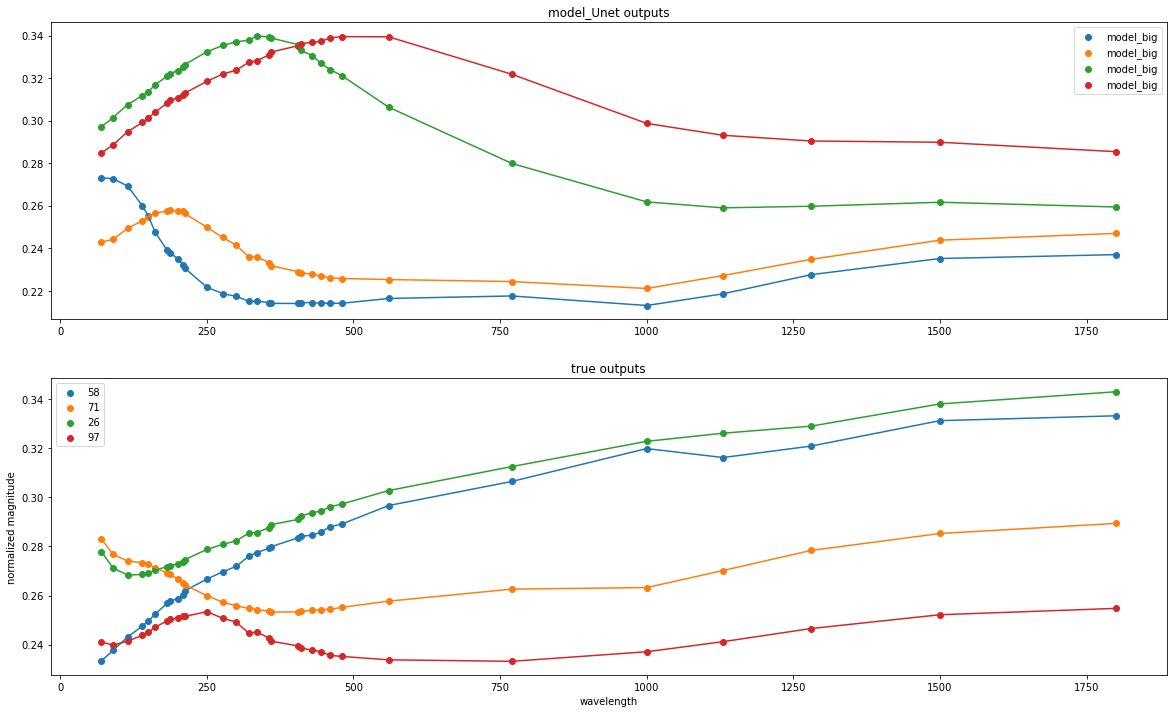

In [11]:

plt.figure(figsize= (20, 12))

for i in range(4):
    plt.subplot(2, 1, 1)
    plt.title('model_Unet outputs')
    sample = (denoise(model_Unet, 31).cpu().detach()).squeeze()
    plt.scatter(filter_wls, sample, label = "model_big")
    plt.plot(filter_wls, sample)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.title('true outputs')
    r = np.random.randint(0, 100)
    plt.scatter(filter_wls, X_scaled[r], label = str(r))
    plt.plot(filter_wls, X_scaled[r])

plt.ylabel("normalized magnitude")
#plt.ylim(-2, 2)
plt.xlabel("wavelength")
plt.legend()

In [7]:
from denoising_diffusion_pytorch.denoising_diffusion_pytorch_1d import Unet1D, GaussianDiffusion1D
import denoising_diffusion_pytorch


Evaluation

In [ ]:
############################################################################
# evaluation
############################################################################


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(192, 192)
        self.fc2 = nn.Linear(192, 4)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x2 = self.fc1(x)
        x = self.relu(x2)
        x = self.fc2(x)

        return x2, x


In [26]:
def train_modelCNN(model, n = len(X_normalized), batch_size = 256, EPOCHS = 50):
    #loss
    loss_fn = nn.MSELoss()
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    #loss data
    running_loss_arr = []

    #training
    model.train(True)
    with open("../runs2/foo.txt", "w") as f:
        f.write("start \n")
    for epoch in range(EPOCHS):
        with open("../runs2/foo.txt", "a") as f:
            f.write("epoch: " + str(epoch) + "\n")
        # generate data_loader
        train_dataloader = DataLoader(MyDataset({"X": X_normalized[:n], "y": y_normalized[:n]}), batch_size=batch_size, shuffle=True)
        
        print('EPOCH ', epoch, ":")
        
        running_loss = 0
        last_loss = 0

        for i, data in enumerate(train_dataloader):
            X_t = data['X'].unsqueeze(1).to(device)
            ys = data['y'].unsqueeze(1).to(device)
            # Zero gradients for every batch
            optimizer.zero_grad()


            # Make predictions for this batch
            _, outputs = model(X_t)

            # Compute the loss and its gradients
            loss = loss_fn(outputs, ys.squeeze())

            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                last_loss = running_loss / 100 # loss per batch
                tb_x = epoch * len(train_dataloader) + i + 1
                running_loss_arr.append([tb_x, last_loss])
                running_loss = 0.
                with open("../runs2/foo.txt", "a") as f:
                    f.write(str(last_loss) + "\n")
        scheduler.step()

        print('LOSS train: ', running_loss_arr[-1])

    model.train(False)
    return np.array(running_loss_arr)


In [27]:
# train all models
model_CNN = CNN().to(device)
n = 1024000
batch_size = 64
epochs = 1
print("#####################################")
print("n: ", n)
print("batch_size: ", batch_size)
print("Epochs: ", epochs)
#print("model: ", model)

running_loss_arr = train_modelCNN(model_CNN, n = n, batch_size = batch_size, EPOCHS = epochs)

torch.save(model_CNN.state_dict(), '../runs2/model_param_CNN.pt')
df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
df_loss.to_csv('../runs2/losses_CNN.csv', index = False)
print("#####################################")

#####################################
n:  1024000
batch_size:  64
Epochs:  1
EPOCH  0 :
LOSS train:  [16000, 0.28883835330605506]
#####################################


In [28]:
def calculate_fid(real_embeddings, generated_embeddings):
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [36]:
model_CNN = CNN().to(device)
model_CNN.load_state_dict(torch.load('../runs2/model_param_CNN.pt'))
model_CNN.train(False)



CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=192, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=4, bias=True)
)

In [1]:
print("yo")

yo


In [41]:
X0 = X_normalized[0].astype('float64')

bs = 10

model_emb = np.array([])
for i in range(bs):

    out_model = denoise(model_Unet, 31)
    lay_model, _ = model_CNN(out_model.unsqueeze(0).unsqueeze(0))
    model_emb = np.append(model_emb, lay_model.cpu().squeeze().detach().numpy())
model_emb = model_emb.reshape(bs, 192)


out_true = torch.tensor(X_scaled[:bs]).unsqueeze(1).to(device)
print(out_true.shape)
true_emb, _ = model_CNN(out_true)
true_emb = true_emb.squeeze().cpu().detach().numpy()

print(model_emb.shape)
print(true_emb.shape)


calculate_fid(true_emb, model_emb)



torch.Size([10, 1, 31])
(10, 192)
(10, 192)


0.04209570776472433

In [285]:
np.sum(true_emb - model_emb , axis = (0, 1))

25914.19755027673

In [ ]:
np.cov(np.arange(20), np.ones(20), rowvar = False)

array([[35.,  0.],
       [ 0.,  0.]])